In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import string
import nltk

%matplotlib inline


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Загрузка и обработка данных

In [121]:
train_df = pd.read_csv('kaggle_movie_train.csv', index_col=0)

In [79]:
# совсем чуть-чуть EDA

train_df = pd.read_csv('kaggle_movie_train.csv', index_col=0)
train_df.head()

,text,genre
id,,
0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
2,"t, summa cum laude and all. And I'm about to l...",comedy
3,"up Come, I have a surprise.... She takes him ...",drama
4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
5,"nd dismounts, just as the other children reach...",drama


In [80]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22579 entries, 0 to 28166
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    22579 non-null  object
 1   genre   22579 non-null  object
dtypes: object(2)
memory usage: 529.2+ KB


In [81]:
train_df.genre.unique()

array(['thriller', 'comedy', 'drama', 'action', 'sci-fi', 'other',
       'romance', 'horror', 'adventure'], dtype=object)

In [82]:
train_df.genre.nunique()

9

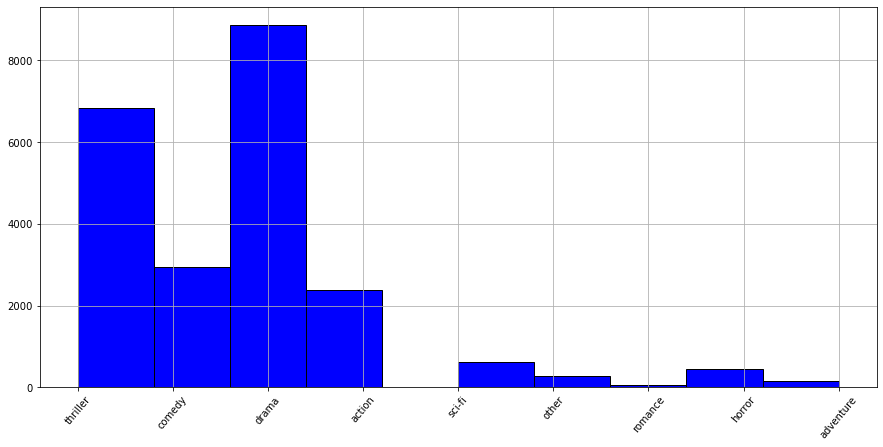

In [83]:
# одним глазком на распределение таргета.

plt.figure(figsize=(15, 7))
plt.hist(
    train_df.genre,
    color='blue',
    edgecolor='black'
)
plt.xticks(rotation=50);
plt.grid()

# Баланса никакого. Надо объединить мелкие группы в одну.

In [84]:
train_df.genre.unique()

array(['thriller', 'comedy', 'drama', 'action', 'sci-fi', 'other',
       'romance', 'horror', 'adventure'], dtype=object)

In [85]:
# В этот список отправляются жанры, которые насчитывают меньше двух тысяч сэмплов

others = train_df[train_df.groupby('genre')['genre'].transform('size') < 2000]
others = list(others.genre.unique())

In [86]:
def genre_filter(genre: str):
    """ little filtering function
    """
    return genre if genre not in others else 'other'

train_df['genre'] = train_df['genre'].apply(genre_filter)

In [122]:
train_df.head(10)

,text,genre
id,,
0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
2,"t, summa cum laude and all. And I'm about to l...",comedy
3,"up Come, I have a surprise.... She takes him ...",drama
4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
5,"nd dismounts, just as the other children reach...",drama
6,breadth of the bluff. Gabe pulls out his ancie...,thriller
7,uilding. A MAN in pajamas runs out into the ra...,thriller
9,ELLES AND RITA HAYWORTH Just disgustingly rich...,drama
10,"Memphis goes back into the garage, Budgy cack...",thriller


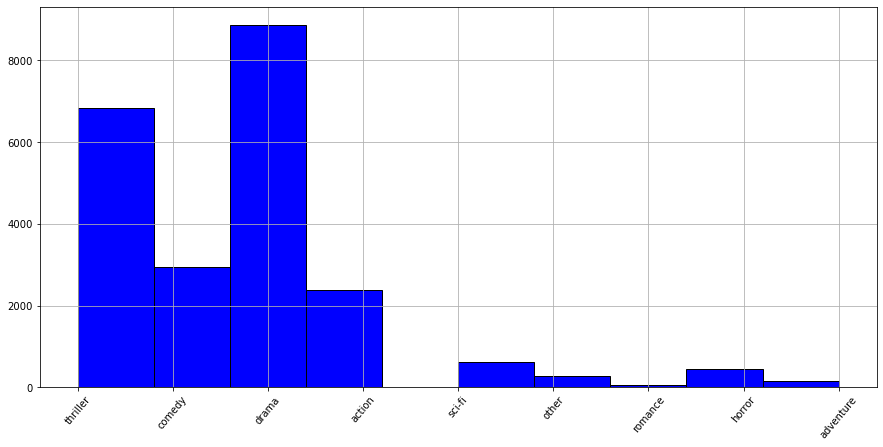

In [123]:
plt.figure(figsize=(15, 7))
plt.hist(
    train_df.genre,
    color='blue',
    edgecolor='black'
)
plt.xticks(rotation=50);
plt.grid()

# Гораздо лучше

In [90]:
# nltk.download('stopwords')
# nltk.download('punkt')

# Для наших целей хватит небольшого словаря к кераса. 
# Запихаем туда также специальные значения

vocabulary = tf.keras.datasets.imdb.get_word_index()
vocabulary = {k: n + 3 for k, n in vocabulary.items()}

vocabulary['<PAD>'] = 0
vocabulary['<START>'] = 1
vocabulary['<UNKNOWN>'] = 2


# стоп-слова
stop_words = nltk.corpus.stopwords.words('english')
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [92]:
# На этом шаге убираем стоп-слова, пунктуацию,
# а также стараемся привести токены к одной словарной форме.  

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

lm = WordNetLemmatizer()

def tokenize_words(raw_text: str):
    text = [i.lower() for i in word_tokenize(raw_text)]
    tokens = [i for i in text if (i not in stop_words and i not in string.punctuation)]
    tokens = ['<START>'] + [lm.lemmatize(token) for token in tokens]
    return ' '.join(tokens)


train_df['description'] = train_df.text.apply(tokenize_words)

In [93]:
# Посмотрим, что получилось. 

print(train_df.description.values[150], '\n', '-' * 16, 'VS')
print(train_df.text.values[150])

<START> r clothes torn body aching sweaty struggle get foot exit barn int halle sethe 's living quarter night sethe open door find child asleep wake notice mrs. garner 's light bedroom window sethe blind rage decides 's one thing must take child meeting place int mrs. garner 's bedroom night mrs. garner lie ailing sleepless night bedroom door open sethe enters appearance tell mrs. garner god sethe .. happened ext sweet home night sethe carried baby girl one arm two boy hand ... move fast ext corn field night arrive meeting place woman crouching field waiting woman hurry 're late sethe hand child howard ma'am ... sethe go tell ya sethe carefully hand baby gir 
 ---------------- VS
r clothes torn, her body aching and sweaty. She struggles to get to her feet and exit the barn. INT. HALLE AND SETHE'S LIVING QUARTERS NIGHT. Sethe opens the door to find her children asleep. She is about to wake them when She notices Mrs. Garner's light is on in her bedroom window. Sethe, blind with rage, dec

###  Подготовка данных к модели

In [94]:
def numerize_text(text: str):
    """function splits the docs and add special token 'unknown' for words absent
    in our vocabulary.
    """
    multi_hot_enc = [vocabulary.get(token, vocabulary['<UNKNOWN>']) for token in text.split()]
    return multi_hot_enc

In [96]:
#Здесь даём каждому слову по индексу. 
X_train = train_df['description'].apply(numerize_text).to_numpy()

# закодируем лейблы. 
genre_labels = {genre: number for number, genre in enumerate(list(train_df.genre.unique()))}
y_train = train_df.genre.apply(lambda x: genre_labels[x]).to_numpy()

# Небольшая проверочка. 
assert X_train.shape == y_train.shape

In [124]:
# Почти готово. Осталось только подвести последовательности к одной размерности.
# Сначала посчитаем, сколько элементов насчитывает самая длинная последовательность

MAX_SEQ_LEN = max([len(seq) for seq in X_train])


X_train = tf.keras.preprocessing.sequence.pad_sequences(
    X_train, 
    value=vocabulary['<PAD>'], # ==0
    padding='post',
    maxlen=MAX_SEQ_LEN
)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=7575)

assert X_train.shape[0] == y_train.shape[0]

###  Построение модели

In [131]:
VOCAB_SIZE = len(vocabulary) + 1
EMB_SIZE = 64
genre_num = train_df.genre.nunique()

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(genre_num, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 64)          5669632   
                                                                 
 bidirectional_23 (Bidirecti  (None, None, 200)        132000    
 onal)                                                           
                                                                 
 bidirectional_24 (Bidirecti  (None, 128)              135680    
 onal)                                                           
                                                                 
 dense_23 (Dense)            (None, 9)                 1161      
                                                                 
Total params: 5,938,473
Trainable params: 5,938,473
Non-trainable params: 0
_________________________________________________________________


In [132]:
BATCH_SIZE = 32
NUM_EPOCHS = 5

checkpoint_path = 'checkpoints'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True
)

history = model.fit(
    X_train, 
    y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=True,
    workers=8,
    callbacks=[callback]
)

Epoch 1/5
346/346 [==============================] - 29s 56ms/step - loss: 1.2089 - acc: 0.5267 - val_loss: 0.7980 - val_acc: 0.7134
Epoch 2/5
346/346 [==============================] - 16s 46ms/step - loss: 0.5157 - acc: 0.8140 - val_loss: 0.6729 - val_acc: 0.7678
Epoch 3/5
346/346 [==============================] - 16s 47ms/step - loss: 0.2669 - acc: 0.9046 - val_loss: 0.6407 - val_acc: 0.7931
Epoch 4/5
346/346 [==============================] - 16s 46ms/step - loss: 0.1576 - acc: 0.9461 - val_loss: 0.7018 - val_acc: 0.7830
Epoch 5/5
346/346 [==============================] - 16s 47ms/step - loss: 0.0720 - acc: 0.9770 - val_loss: 0.6860 - val_acc: 0.8229


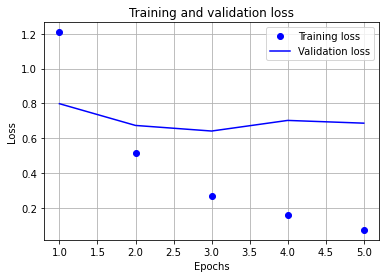

In [133]:
epochs = range(1, len(history.history['acc']) + 1)

plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

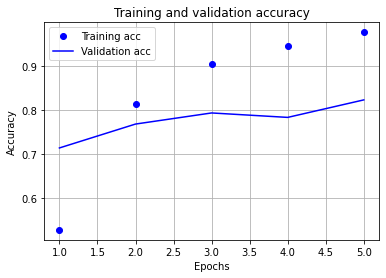

In [134]:
plt.figure()
plt.plot(epochs, history.history['acc'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()